<a href="https://colab.research.google.com/github/jocelynbaduria/cmpe-258-hw1/blob/main/Jocelyn_Baduria_Assignment_1_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Parameters

In [32]:
# 13b.  Change the BATCH_SIZE = 64
# BATCH_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 10

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [33]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [34]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

### tf.data.Dataset: parse files and prepare training and validation datasets
Please read the [best practices for building](https://www.tensorflow.org/guide/performance/datasets) input pipelines with tf.data.Dataset

In [35]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

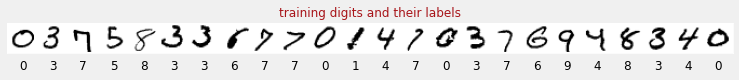

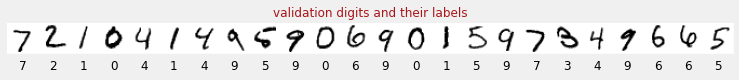

In [36]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

### Keras model
If you are not sure what cross-entropy, dropout, softmax or batch-normalization mean, head here for a crash-course: [Tensorflow and deep learning without a PhD](https://github.com/GoogleCloudPlatform/tensorflow-without-a-phd/#featured-code-sample)

In [29]:
model = tf.keras.Sequential(
  [
    # 11a. Reshape back the imsges flattened vector into 28x28x1 images(1 channel for grayscale images)
      # tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28,1)),
   
    # 6. Adding Layers Sigmoid function resulted to poor performance of the model.
    # tf.keras.layers.Dense(200, activation='sigmoid'),
    # tf.keras.layers.Dense(60, activation='sigmoid'),
   
    #7a. Replace all activation='sigmoid with activation='relu
      # tf.keras.layers.Dense(200, activation='relu'),
      # tf.keras.layers.Dense(60, activation='relu'),
      # tf.keras.layers.Dense(10, activation='softmax')

    #9a. Increase the depth of the model to at least 4 dense layers and retrain using the following number 
    #  of neurons 200, 100, 60, 10.
      # tf.keras.layers.Dense(200, activation='relu'),
      # tf.keras.layers.Dense(100, activation='relu'),
      # tf.keras.layers.Dense(60, activation='relu'),
      # tf.keras.layers.Dense(10, activation='softmax')

    #9c. Apply regularization techniques call dropout rate 0.25 when training the data. 
    # Dont add after softmax layer because it will dropped the predicted probabilities.
    # Then retrain the model and check the results
   
      # tf.keras.layers.Dense(200, activation='relu'),
      # tf.keras.layers.Dropout(0.25),
      # tf.keras.layers.Dense(100, activation='relu'),
      # tf.keras.layers.Dropout(0.25),
      # tf.keras.layers.Dense(60, activation='relu'),
      # tf.keras.layers.Dropout(0.25),
      # tf.keras.layers.Dense(10, activation='softmax')

     #11b. Modify your model into a convolutional model. Remove the dropout
       # In Kerss the syntax for relu activated convolutiona layer and the padding can have tow values 
       # "same": pad with zeros so as to produce outputs of the same width/height as the input
       # "valid": no padding, only use real pixels. We do use pasdding here use "same". 
       # tf.keras.layers.Conv2D(kernel_size=3, filters=12, padding='same', activation='relu'),
       # For strided convolution see syntax below.   
       # tf.keras.layers.Conv2D(kernel_size=6, filters=24, padding='same', activation='relu', strides=2),
       # # tf.keras.layers.Dropout(0.4),
       # tf.keras.layers.Conv2D(kernel_size=6, filters=32, padding='same', activation='relu', strides=2),
   
     #13a. Modify each layer: remoe the activation from the layer itself. Set use_bias=False
      # The scale factor can be turned off for Relu activation. 
      # Batch norm goes between the layer and its activation
        # tf.keras.layers.BatchNormalization(scale=False, center=True),
      # Finish with the activation.
        # tf.keras.layers.Activation('relu'),

      tf.keras.layers.Conv2D(kernel_size=3, filters=12, padding='same', use_bias=False),
      tf.keras.layers.BatchNormalization(scale=False, center=True),
      tf.keras.layers.Activation('relu'),
   
       # For strided convolution see syntax below.   
      tf.keras.layers.Conv2D(kernel_size=6, filters=24, padding='same', use_bias=False, strides=2),
      tf.keras.layers.BatchNormalization(scale=False, center=True),
      tf.keras.layers.Activation('relu'),

      tf.keras.layers.Conv2D(kernel_size=6, filters=32, padding='same', use_bias=False, strides=2),
      tf.keras.layers.BatchNormalization(scale=False, center=True),
      tf.keras.layers.Activation('relu'),
   
      # To flatten the curve into vector so that it can be consumed by a dense layer
      tf.keras.layers.Flatten(),
  
      # For dense layers the syntax has no changed.
      # tf.keras.layers.Dense(200, activation='relu'),
   
      #13a. Change the dense layer and remove the activation='relu' to use_bias=False
      # Follow the steps above for BatchNormalization and Activation function.
      tf.keras.layers.Dense(200, use_bias=False),
      tf.keras.layers.BatchNormalization(scale=False, center=True),
      tf.keras.layers.Activation('relu'),

      # 12a. add a dropout between the two dense layer  with dropout rate 40%(0.4)
      # tf.keras.layers.Dropout(0.4),
   
      # 13b. Change dropout rate 40%(0.3)  
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

# 7b. Replace optimizer = 'sgd' with optimizer 'adam'. Retrain the model again and check the results
  # model.compile(optimizer='sgd' to model.compile(optimizer='adam',
  
# 8a. Replace the default value of adam optimizer(optimizer = 'adam') from 0.001 to 0.01 with 
# using the actual instance of Adam optimizer optimizer = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
# 8b Please also change the zoom factor from zoom=1 to zoom=5. Then rerun the model again 
# Check the results 
# plot_training = PlotTraining(sample_rate=10, zoom=5)

#9b Bump the zoom factor to 10 in PlotTraining
#plot_training = PlotTraining(sample_rate=10, zoom=10)

#11c Please bump up the zoom in PlotTraining to to 16. Then retrain the model
plot_training = PlotTraining(sample_rate=10, zoom=16)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 12)        108       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 12)        36        
_________________________________________________________________
activation_4 (Activation)    (None, 28, 28, 12)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 24)        10368     
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 24)        72        
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 24)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


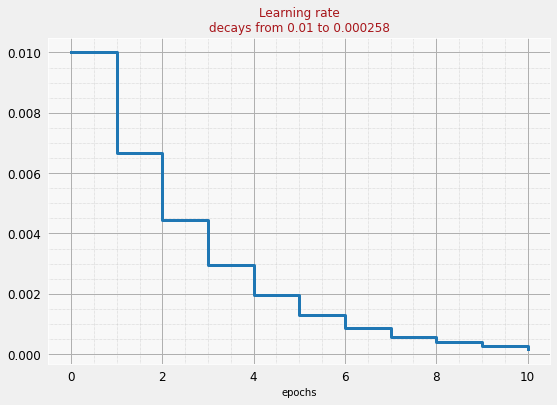

In [37]:
# 8c. Implement a learning scheduler that decays the learning rate exponentially
# Learning rate decay function
def lr_decay(epoch):
 # return 0.01 * math.pow(0.6,epoch)
   # 13b. Change the learning rate decay to 0.666
  return 0.01 * math.pow(0.666,epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, EPOCHS)

### Train and validate the model

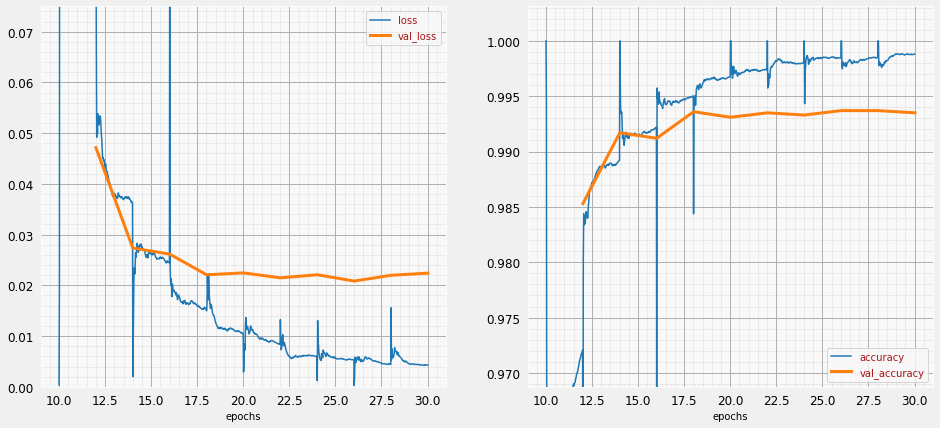

In [38]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
# 8d Add the lr_decay_callback to model.fit callbacks[plot_training, lr_decay_callback]
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

### Visualize predictions

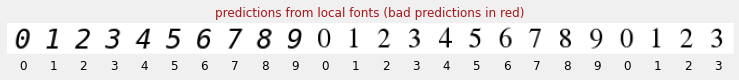

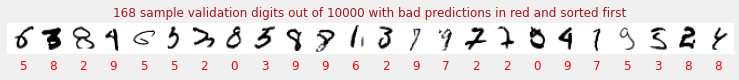

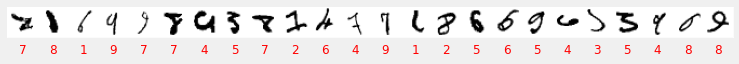

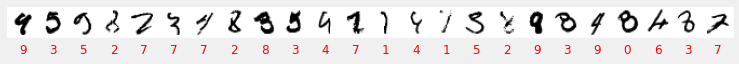

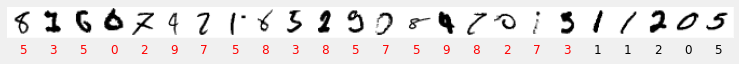

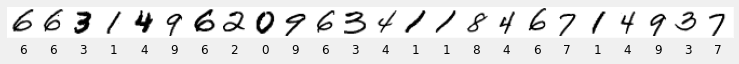

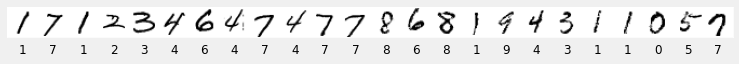

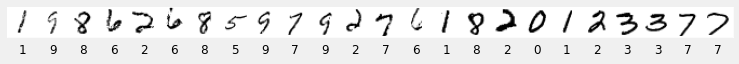

In [13]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)

## License



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose
